In [2]:
%matplotlib inline
import os 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import seaborn as sns

accepted_original = pd.read_csv('accepted2017.csv', encoding = "ISO-8859-1")
accepted = accepted_original

In [70]:
# Drop columns

accepted = accepted.drop(['title', 'funded_amnt'], axis = 1)
# accepted = accepted.drop(['title', 'funded_amnt', 'funded_amnt_inv'], axis = 1)

# linear combination of other columns
accepted = accepted.drop(['out_prncp_inv','total_rec_prncp','total_pymnt_inv'], axis = 1)

# repeated information
accepted = accepted.drop(["fico_range_low", "last_fico_range_low",
                         'avg_cur_bal',
                         'addr_state', 'initial_list_status', 'pymnt_plan',
                         'application_type', 'hardship_flag', 'disbursement_method','debt_settlement_flag','sub_grade',
                         'zip_code', 'id','policy_code','tax_liens', 'tax_liens'], axis = 1)


In [72]:
# Transform variables
accepted['issue_d'] = pd.to_datetime(accepted.issue_d)
accepted['last_pymnt_d'] = pd.to_datetime(accepted['last_pymnt_d'])
accepted['issue_yr'] = accepted.issue_d.dt.year
accepted['earliest_cr_line'] = pd.to_datetime(accepted.earliest_cr_line)

accepted['early_cr_yr'] = accepted.earliest_cr_line.dt.year

accepted.term = accepted.term.apply(str)
accepted['term'] = accepted['term'].apply(lambda x: x.strip().split(" ")[0])

currentDate = accepted.last_pymnt_d.max() # Dec 01, 2017
# accepted['ratio_prin']=  (accepted.total_pymnt - accepted.total_rec_int - accepted.total_rec_late_fee)/ accepted.loan_amnt
# accepted['ratio_prin'] = 1- accepted['ratio_prin']

In [98]:
currentDate

Timestamp('2017-12-01 00:00:00')

In [73]:
leq1mil = accepted['annual_inc'] <= 1e6
accepted = accepted[leq1mil]
accepted = accepted[accepted.dti < 100.0]

accepted.emp_length[accepted.emp_length == '10+ years'] = '10 years'
accepted.emp_length[accepted.emp_length == '< 1 year'] = '0 year'
accepted.emp_length = accepted.emp_length.apply(lambda x: int(x.split(' ')[0]))

accepted.emp_title = accepted.emp_title.apply(lambda x: x.strip().lower())
accepted.emp_title[(accepted.emp_title == 'registered nurse') | (accepted.emp_title == 'rn')] = 'nurse'

accepted.home_ownership = accepted.home_ownership.replace(['ANY', 'NONE'], 'RENT')

accepted['target'] = 1
accepted.loc[(accepted.loan_status == 'Current') |(accepted.loan_status == 'Fully Paid') | (accepted.loan_status == 'In Grace Period'),
      'target'] = 0


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


### Income distribution
Because of the large number of observations that we have, we can construct a reliable distribution of annual incomes. Because people will most likely lie on their incomes when their income is low, we can filter out for data if:
- Income is lower than a limit
- Income is higher than limit but has been verified by Lending Club

The choice of limit of $70,000 is arbitrary. The choice to show only professions for which we have more than 400 is have an accurate picture of the distribution and to include certain profession of interest like *police officer*.

In [6]:
pd.options.display.float_format = '{:,.2f}'.format
salary_limit = 7e4
emp_annual_all = accepted.loc[(accepted['annual_inc'] < salary_limit) | ((accepted['annual_inc'] >= salary_limit) & (accepted['verification_status'] == 'Verified')),
                              ['emp_title','annual_inc']].groupby('emp_title')
summ_inc = emp_annual_all.agg(['mean','median','min','max', 'count'])
summ_inc.columns = summ_inc.columns.levels[1]
summ_inc = summ_inc.sort_values(by = ['count','min'], ascending = False)
summ_inc = summ_inc[summ_inc['count'] >= 450].sort_values(by = ['count','min'], ascending = False)

summ_inc

,mean,median,min,max,count
emp_title,,,,,
teacher,"55,043.65","54,000.00","8,000.00","156,000.00",5156
manager,"62,122.41","55,000.00","12,000.00","500,000.00",3941
nurse,"68,640.56","62,000.00","13,000.00","300,000.00",3463
owner,"68,771.41","54,000.00","8,400.00","1,000,000.00",2841
driver,"53,794.78","52,000.00","11,000.00","180,000.00",2277
supervisor,"56,885.79","55,000.00","10,000.00","745,000.00",2212
office manager,"49,536.38","49,500.00","7,992.00","255,000.00",1657
sales,"62,862.41","55,000.00","12,000.00","471,000.00",1583
truck driver,"58,677.80","58,000.00","14,000.00","435,000.00",1285


### Fico Range and grade

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


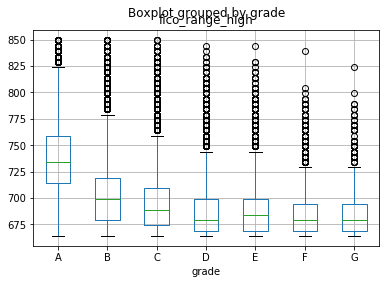

In [7]:
accepted.boxplot(by = 'grade', column = 'fico_range_high')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0,0.5,'FICO change at observation')

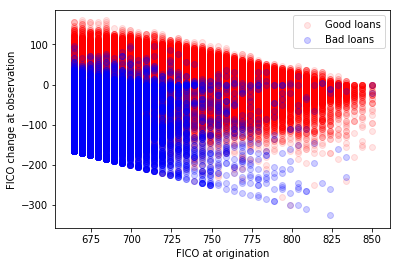

In [11]:
fico_change_loanstat = accepted[['fico_range_high','last_fico_range_high','loan_status','target']]
fico_change_loanstat['change'] = fico_change_loanstat.last_fico_range_high - fico_change_loanstat.fico_range_high

chargeoff = accepted['target'] == 1

plt.scatter(x = 'fico_range_high', y = 'change', data = fico_change_loanstat[~chargeoff], color = 'r', alpha = 0.1, label = "Good loans")
plt.scatter(x = 'fico_range_high', y = 'change', data = fico_change_loanstat[chargeoff], color = 'b', alpha = 0.2, label = "Bad loans")
plt.legend()
plt.xlabel("FICO at origination")
plt.ylabel("FICO change at observation")


### Modeling
If the default status is our variable of interest, we have 2 ways to approach this problem:
- Use a classification approach to see whether the loan is default or not
- Use a survival approach

In [104]:
########
# Option 1 - no lookahead
########
def GetXY_1(accepted):
    train = accepted.loc[(accepted['annual_inc'] < salary_limit) | ((accepted['annual_inc'] >= salary_limit) & (accepted['verification_status'] == 'Verified'))]

    train = train[train.loan_status != 'Current']

    lookAheadFeatures = ["out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",
                         "total_rec_prncp","total_rec_int","total_rec_late_fee",
                         "recoveries","collection_recovery_fee","last_pymnt_d",
                         "last_pymnt_amnt","last_credit_pull_d",
                         "last_fico_range_high","collections_12_mths_ex_med","tot_coll_amt"]

    for feature in lookAheadFeatures:
        if feature in train.columns:
            train = train.drop(feature, axis = 1)

    train['early_cr_line_month'] = -round((train.earliest_cr_line - currentDate) / np.timedelta64(1, 'M'))
    
    train = train.drop(['issue_yr','issue_d', 'purpose','emp_title',
                        'earliest_cr_line','verification_status'], axis = 1)
    train = pd.get_dummies(train, columns = ['term','grade','home_ownership'], drop_first = True)
    X = train.drop(['loan_status', 'target'], axis = 1)
    y = train.target
    
    return X, y


In [83]:
########
# Option 2
# Feature from Vincenzo Pota
########

def GetXY_2(accepted):
    features = ['loan_amnt', 
                # 'amt_difference', 
                'term', 'installment', 'grade','emp_length',
                'home_ownership', 'annual_inc',
                'purpose', 'dti', 
                'delinq_2yrs','inq_last_6mths',
                # 'pub_rec_cat', 'acc_ratio', 
                # 'delinq_2yrs_cat', 'inq_last_6mths_cat', 'pub_rec_cat', 'acc_ratio', 
                'open_acc', 'pub_rec', 
                # 'initial_list_status',  
                'loan_status', 'target'
               ]

    train = accepted.loc[(accepted['annual_inc'] < salary_limit) | ((accepted['annual_inc'] >= salary_limit) & (accepted['verification_status'] == 'Verified'))]

    train = train[train.loan_status != 'Current']
    train = train[features]

    train = pd.get_dummies(train, columns = ['term','grade','home_ownership','purpose'], drop_first = True)
    X = train.drop(['loan_status', 'target'], axis = 1)
    y = train.target
    
    return X, y


In [99]:
########
#
# Option 3: Training with lookahead features
#
########
def GetXY_3(accepted):
    train = accepted.loc[(accepted['annual_inc'] < salary_limit) | ((accepted['annual_inc'] >= salary_limit) & (accepted['verification_status'] == 'Verified'))]
    # train = train[train.loan_status != "Current"]

    train['loan_seasoning'] = (train.issue_d - train.last_pymnt_d)/np.timedelta64(1, 'M')
    train['loan_seasoning'] = - train['loan_seasoning']/train['term'].apply(float)

    train['early_cr_line_month'] = -round((train.earliest_cr_line - currentDate) / np.timedelta64(1, 'M'))

    #money_amnt = ['loan_amnt','tot_hi_cred_lim', 'total_bc_limit', 'total_il_high_credit_limit','total_rev_hi_lim', 
    #              'total_bal_ex_mort', 'revol_bal','tot_cur_bal',
    #              'bc_open_to_buy',  
    #              'out_prncp','total_pymnt','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee']
    #
    #for x in money_amnt:
    #    train["pct_" + x] = train[x] / train['annual_inc']

    train["pct_" + 'tot_coll_amt'] = train['tot_coll_amt'] / train['annual_inc']

    train['installment_pct'] = train['installment'] * 12 / train['annual_inc'] # installment as a percentage of annual_inc/ 12
    train['fico_change'] = train.fico_range_high - train.last_fico_range_high

    #train = train.drop(money_amnt + ['installment', 'tot_coll_amt'], axis = 1)
    #train = train.drop('ratio_prin', axis = 1)
    train = train.drop('last_fico_range_high', axis = 1)

    train = train.drop(['issue_yr','issue_d', 'purpose','emp_title',
                        'earliest_cr_line','verification_status'], axis = 1)

    train = train.drop('last_credit_pull_d', axis = 1)

    train = train.drop(['last_pymnt_d','last_pymnt_amnt'],axis = 1)

    train = pd.get_dummies(train, columns = ['term','grade','home_ownership'], drop_first = True)
    
    X = train.drop(['loan_status', 'target'], axis = 1)
    y = train.target
    return X, y

We need to create training and testing data

In [105]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
   
sm = SMOTE(random_state = 0, ratio = 1.0) 
X, y = GetXY_1(accepted)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_train_smote, y_train_smote = sm.fit_sample(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)


D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Evaluate the model:

In [77]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
import timeit
from sklearn.externals import joblib

def run_models(X_train, y_train, X_test, y_test, date_txt, model_type = 'Non-balanced'):
    # Thanks to Vince Pota for the code
    # https://www.kaggle.com/vincepota/predicting-customers-who-will-charge-off
    clfs = {
        'SGDClassifier' : SGDClassifier(loss="log"),
        # Logistic Regression L1 takes more than an hour to train
        'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
        'GaussianNB': GaussianNB(),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=500, max_depth = 3)
    }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):
        start = timeit.default_timer()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        stop = timeit.default_timer()
        print('Run time is', stop - start)
        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)
        
        # Dump model as file to be used later 
        
        logistic = joblib.dump(clf, clf_name + '.'+ date_txt + '.pkl')
        np.savetxt(clf_name + "_y_score" + date_txt + ".csv", y_score, delimiter=",")
        
        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix, clfs

D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Run time is 0.0522582002231502
computing SGDClassifier - Balanced 
Run time is 11.983705579143134
computing GradientBoosting - Balanced 
Run time is 0.07172745181014761
computing GaussianNB - Balanced 
Run time is 17.65800105557537
computing RandomForestClassifier - Balanced 


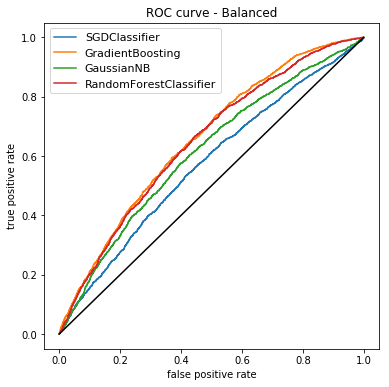

In [106]:
date_txt = '0219_option_1'
models_report, conf_matrix, clfs = run_models(X_train_smote, y_train_smote, X_test_scaled, y_test, date_txt, 'Balanced')

It appears that Gradient Boosting performs the best and high the highest AUC. Let's take a closer look at  Gradient Boosting results.

(0.0, 1.0)

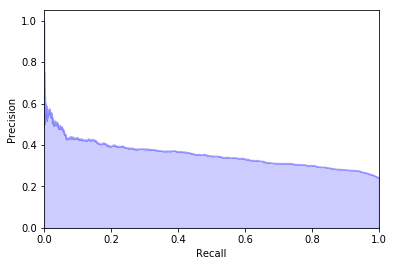

In [107]:
# y_score = pd.read_csv("GradientBoosting_y_score" + date_txt + ".csv", header = None)
y_score = clfs['GradientBoosting'].predict_proba(X_test_scaled)[:,1]

# Source
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])



In [108]:
models_report

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,SGDClassifier,0.10,0.57,0.28,0.55,0.37,Balanced
1,GradientBoosting,0.13,0.66,0.41,0.16,0.23,Balanced
2,GaussianNB,0.15,0.61,0.31,0.55,0.40,Balanced
3,RandomForestClassifier,0.18,0.65,0.33,0.59,0.42,Balanced


I picked the thresholds so that we could have True Positive Rate (Recall) 95%, 97%, and 99%, ie: we are able to predict the corresponding number of loans that are classified as Bad. Our prediction has low precision score, say 6% (with recall = 97%). This means that whenever we predict a loan is Bad, only 6% of the time the loan turns out to be actually bad.

Depending on the business needs, we can tolerate the low precision or not.

### Revising the model

We have constructed a model that can successfully predict whether the loan will be bad loan or not. It would be interesting to see which feature has the most predictive values. Examining feature importances as calibrated by Gradient Boosting and Random Forest, I found a number of variables that have high predictive values:
- Early_cr_line_month (earliest credit line in months)
- Fico change: fico change calculates near the end
- Interest Rate: make sense, because interest rate is decided by grade
- Total Received late fee: the more late fees, the higher the loans and the longer they have delayed paying. On the other hand, this fee is actually received. So people who have paid late fees are more likely to default.

- Loan Seasoning: relatively high for tree models, but quite small for Logistic Regression L1

Can we further use this model to infer on the impact of payment?

In [110]:
ModelParam = pd.DataFrame({'feature': X.columns, 'GBM_importance': clfs['GradientBoosting'].feature_importances_,
                          'RFC_importance': clfs['RandomForestClassifier'].feature_importances_,
                          })
ModelParam.to_csv(date_txt +"FeatureImportance.csv")


In [69]:
# Reset the value
accepted = accepted_original

